In [23]:
import os

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import torch
import torch.nn as nn

dtype = torch.float

if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

my_computer_is_slow = True

In [24]:
# Mocking sound data
second = 1
ms = 1e-3
Hz = 1
dt = 1 * ms
anf_per_ear = 100 # repeats of each ear with independent noise
envelope_power = 2 # higher values make sharper envelopers, easier
rate_max = 600 * Hz # maximum Poisson firing rate
f = 20 * Hz
duration = .1*second # stimulus duration
duration_steps = int(np.round(duration/dt))
input_size = 2*anf_per_ear

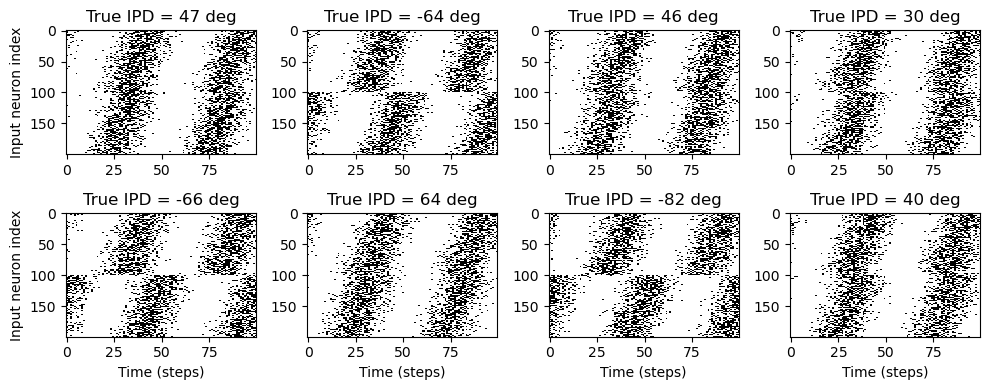

In [25]:
# Generate an input signal (spike array) from array of true IPDs
def input_signal(ipd):
  num_samples = len(ipd)
  T = np.arange(duration_steps)*dt
  phi = 2 * np.pi * (f*T+np.random.rand())
  theta = np.zeros((num_samples, duration_steps, 2*anf_per_ear))
  phase_delays = np.linspace(0, np.pi/2, anf_per_ear)

  theta[:, :, :anf_per_ear] = phi[np.newaxis, :, np.newaxis] + phase_delays[np.newaxis, np.newaxis, :]
  theta[:, :, anf_per_ear:] = phi[np.newaxis, :, np.newaxis] + phase_delays[np.newaxis, np.newaxis, :] + ipd[:, np.newaxis, np.newaxis]

  spikes = np.random.rand(num_samples, duration_steps, 2*anf_per_ear) < rate_max*dt*(0.5*(1+np.sin(theta)))**envelope_power
  return spikes

def random_ipd_input_signal(num_samples, tensor=True):
  ipd = np.random.rand(num_samples)*np.pi-np.pi/2 # uniformly random in (-pi/2, pi/2)
  spikes = input_signal(ipd)
  if tensor:
    ipd = torch.tensor(ipd, device=device, dtype=dtype)
    spikes = torch.tensor(spikes, device=device, dtype=dtype)
  return ipd, spikes

ipd, spikes = random_ipd_input_signal(8)
plt.figure(figsize=(10, 4), dpi=100)
for i in range(8):
  plt.subplot(2, 4, i+1)
  plt.imshow(spikes[i, :, :].T, aspect='auto', interpolation='nearest', cmap=plt.cm.gray_r)
  plt.title(f'True IPD = {int(ipd[i]*180/np.pi)} deg')
  if i>=4:
    plt.xlabel('Time (steps)')
  if i%4==0:
    plt.ylabel('Input neuron index')
plt.tight_layout()

Classification approach

In [26]:
# classes at 15 degree increments
num_classes = int(180/15)
print(f"Number of classes = {num_classes}")

def discretise(ipds):
  return ((ipds+np.pi/2)*num_classes/np.pi).long()

def continuise(ipd_indices): # convert indices back to IPD midpoints
  return (ipd_indices+0.5)/num_classes*np.pi-np.pi/2

Number of classes = 12


In [27]:
# Training
if my_computer_is_slow:
  batch_size = 64
  n_training_batches = 64
else:
  batch_size = 128
  n_training_batches = 128
n_testing_batches = 32
num_samples = batch_size*n_training_batches

def data_generator(ipds, spikes):
  perm = torch.randperm(spikes.shape[0])
  spikes = spikes[perm, :, :]
  ipds = ipds[perm]
  n, _, _ = spikes.shape
  n_batch = n//batch_size
  for i in range(n_batch):
    x_local = spikes[i*batch_size:(i+1)*batch_size, :, :]
    y_local = ipds[i*batch_size:(i+1)*batch_size]
    yield x_local, y_local


With spikes

In [28]:
beta = 5

class SurrGradSpike(torch.autograd.Function):
  @staticmethod
  def forward(ctx, input):
    ctx.save_for_backward(input)
    out = torch.zeros_like(input)
    out[input>0] = 1.0
    return out

  @staticmethod
  def backward(ctx, grad_output):
    input, = ctx.saved_tensors
    grad = grad_output*beta*torch.sigmoid(beta*input)*(1-torch.sigmoid(beta*input))
    return grad

spike_fn = SurrGradSpike.apply

In [74]:
num_hidden = 30

# Weights and uniform weight initialisation
def hidden():
    # Input to hidden layer
    W1 = nn.Parameter(torch.empty((input_size, num_hidden), device=device, dtype=dtype, requires_grad=True))
    fan_in, _ = nn.init._calculate_fan_in_and_fan_out(W)
    bound = 1 / np.sqrt(fan_in)
    nn.init.uniform_(W1, -bound, bound)
    # Hidden layer to output
    W2 = nn.Parameter(torch.empty((num_hidden, num_classes), device=device, dtype=dtype, requires_grad=True))
    fan_in, _ = nn.init._calculate_fan_in_and_fan_out(W)
    bound = 1 / np.sqrt(fan_in)
    nn.init.uniform_(W2, -bound, bound)
    return W1, W2

# Run the simulation
def snn(input_spikes, W1, W2, tau=20*ms, silence=None):
    # First layer: input to hidden
    v = torch.zeros((batch_size, num_hidden), device=device, dtype=dtype)
    s = torch.zeros((batch_size, num_hidden), device=device, dtype=dtype)
    s_rec = [s]
    h = torch.einsum("abc,cd->abd", (input_spikes, W1))
    alpha = np.exp(-dt/tau)
    for t in range(duration_steps - 1):
        new_v = (alpha*v + h[:, t, :])*(1-s) # multiply by 0 after a spike
        s = spike_fn(v-1) # threshold of 1
        v = new_v
        s_rec.append(s)
    s_rec = torch.stack(s_rec, dim=1)
    if silence is not None:
        s_rec = s_rec * silence # silence specific neurons activations
    # Second layer: hidden to output
    v = torch.zeros((batch_size, num_classes), device=device, dtype=dtype)
    s = torch.zeros((batch_size, num_classes), device=device, dtype=dtype)
    v_rec = [v]
    h = torch.einsum("abc,cd->abd", (s_rec, W2))
    alpha = np.exp(-dt/tau)
    for t in range(duration_steps - 1):
        v = alpha*v + h[:, t, :]
        v_rec.append(v)
    v_rec = torch.stack(v_rec, dim=1)
    # Return recorded membrane potential of output
    return v_rec, s_rec

In [30]:
def init_weight_matrix():
    # Note that the requires_grad=True argument tells PyTorch that we'll be computing gradients with
    # respect to the values in this tensor and thereby learning those values. If you want PyTorch to
    # learn some gradients, make sure it has this on.
    W = nn.Parameter(torch.empty((input_size, num_classes), device=device, dtype=dtype, requires_grad=True))
    fan_in, _ = nn.init._calculate_fan_in_and_fan_out(W)
    bound = 1 / np.sqrt(fan_in)
    nn.init.uniform_(W, -bound, bound)
    return W

W = init_weight_matrix()

def init_weight_matrices():
    # Input to hidden layer
    W1 = nn.Parameter(torch.empty((input_size, num_hidden), device=device, dtype=dtype, requires_grad=True))
    fan_in, _ = nn.init._calculate_fan_in_and_fan_out(W)
    bound = 1 / np.sqrt(fan_in)
    nn.init.uniform_(W1, -bound, bound)
    # Hidden layer to output
    W2 = nn.Parameter(torch.empty((num_hidden, num_classes), device=device, dtype=dtype, requires_grad=True))
    fan_in, _ = nn.init._calculate_fan_in_and_fan_out(W)
    bound = 1 / np.sqrt(fan_in)
    nn.init.uniform_(W2, -bound, bound)
    return W1, W2

Want loss for epoch 1 to be about 2.48, multiply m by constant to get this
Epoch 1: loss=1.79860
Epoch 2: loss=1.07768
Epoch 3: loss=0.85523
Epoch 4: loss=0.74928
Epoch 5: loss=0.68967
Epoch 6: loss=0.67293
Epoch 7: loss=0.57866
Epoch 8: loss=0.55842
Epoch 9: loss=0.52316
Epoch 10: loss=0.48962
(4096, 100, 30)
(4096,)


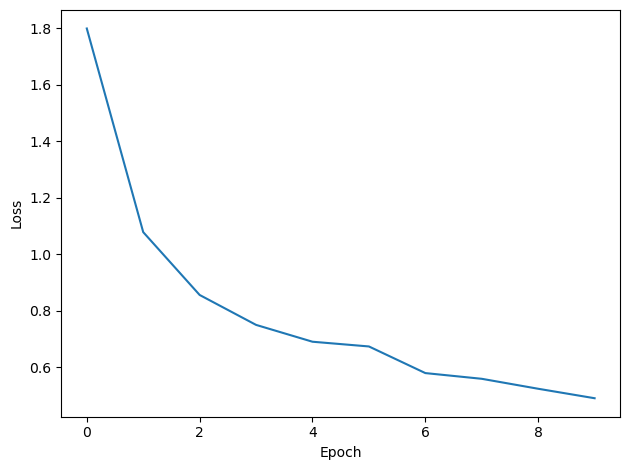

In [31]:
nb_epochs = 10
lr = 0.01

ipds, spikes = random_ipd_input_signal(num_samples)
W1, W2 = init_weight_matrices()

optimizer = torch.optim.Adam([W1, W2], lr=lr)
log_softmax_fn = nn.LogSoftmax(dim=1)
loss_fn = nn.NLLLoss()
s_rec_results = []
s_labels_results = np.array([])

print(f"Want loss for epoch 1 to be about {-np.log(1/num_classes):.2f}, multiply m by constant to get this")

loss_hist = []
for i, e in enumerate(range(nb_epochs)):
  local_loss = []
  for x_local, y_local in data_generator(discretise(ipds), spikes):
    output, s_rec = snn(x_local, W1, W2)
    if i == nb_epochs - 1:
      # process the last epoch as the hidden layer we want to analyse
      s_rec_results.append(s_rec.detach().numpy())
      s_labels_results = np.append(s_labels_results, y_local.detach().numpy())
    m = torch.sum(output, 1) * 0.01
    loss = loss_fn(log_softmax_fn(m), y_local)
    local_loss.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  loss_hist.append(np.mean(local_loss))
  print("Epoch %i: loss=%.5f"%(e+1, np.mean(local_loss)))

s_rec_results = np.concatenate(s_rec_results, axis=0)
print(s_rec_results.shape)
print(s_labels_results.shape)
plt.plot(loss_hist)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.tight_layout()

Chance accuracy level: 8.3%

Train classifier accuracy: 82.3%
Train absolute error: 4.8 deg

Test classifier accuracy: 62.5%
Test absolute error: 7.1 deg


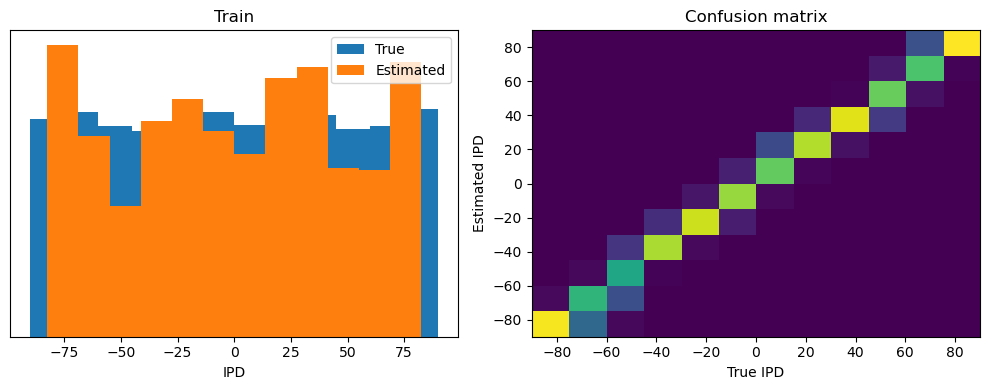

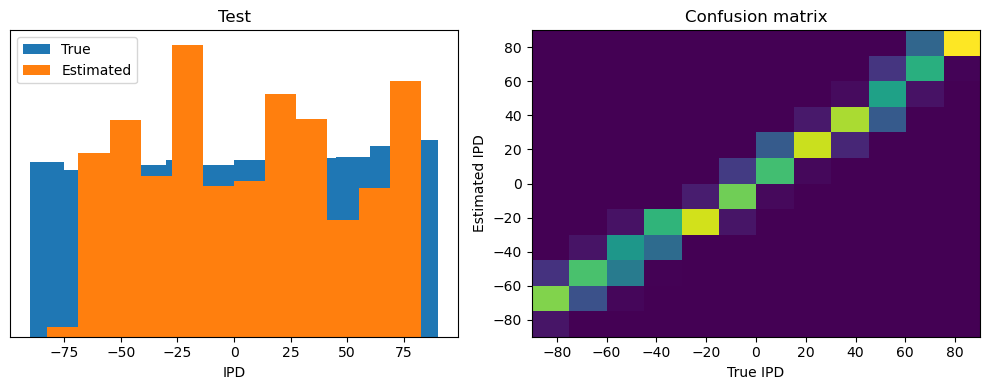

In [51]:
# Analyse
def analyse(ipds, spikes, label, run):
  accs = []
  ipd_true = []
  ipd_est = []
  confusion = np.zeros((num_classes, num_classes))
  for x_local, y_local in data_generator(ipds, spikes):
    y_local_orig = y_local
    y_local = discretise(y_local)
    output = run(x_local)
    m = torch.sum(output, 1)
    _, am = torch.max(m, 1)
    tmp = np.mean((y_local == am).detach().cpu().numpy())
    for i, j in zip(y_local.detach().cpu().numpy(), am.detach().cpu().numpy()):
      confusion[j, i] += 1
    ipd_true.append(y_local_orig)
    ipd_est.append(continuise(am.detach().cpu().numpy()))
    accs.append(tmp)
  ipd_true = np.hstack(ipd_true)
  ipd_est = np.hstack(ipd_est)
  abs_errors_deg = abs(ipd_true-ipd_est)*180/np.pi
  print()
  print(f"{label} classifier accuracy: {100*np.mean(accs):.1f}%")
  print(f"{label} absolute error: {np.mean(abs_errors_deg):.1f} deg")

  plt.figure(figsize=(10, 4), dpi=100)
  plt.subplot(121)
  plt.hist(ipd_true*180/np.pi, bins=num_classes, label='True')
  plt.hist(ipd_est*180/np.pi, bins=num_classes, label='Estimated')
  plt.xlabel("IPD")
  plt.yticks([])
  plt.legend(loc='best')
  plt.title(label)
  plt.subplot(122)
  confusion /= np.sum(confusion, axis=0)[np.newaxis, :]
  plt.imshow(confusion, interpolation='nearest', aspect='auto', origin='lower', extent=(-90, 90, -90, 90))
  plt.xlabel('True IPD')
  plt.ylabel('Estimated IPD')
  plt.title('Confusion matrix')
  plt.tight_layout()
  
print(f"Chance accuracy level: {100*1/num_classes:.1f}%")
run_func = lambda x: snn(x, W1, W2)[0]
analyse(ipds, spikes, 'Train', run=run_func)
ipds_test, spikes_test = random_ipd_input_signal(batch_size*n_testing_batches)
analyse(ipds_test, spikes_test, 'Test', run=run_func)

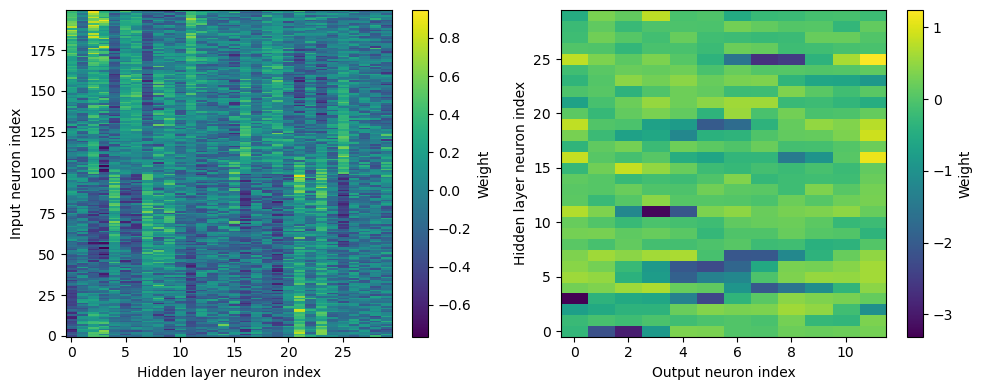

In [33]:
# Parameters matrix for W1 and W2
plt.figure(figsize=(10, 4), dpi=100)
plt.subplot(121)
plt.imshow(W1.detach().cpu().numpy(), interpolation='nearest', aspect='auto', origin='lower')
plt.ylabel('Input neuron index')
plt.xlabel('Hidden layer neuron index')
plt.colorbar(label="Weight")
plt.subplot(122)
plt.imshow(W2.detach().cpu().numpy(), interpolation='nearest', aspect='auto', origin='lower')
plt.ylabel('Hidden layer neuron index')
plt.xlabel('Output neuron index')
plt.colorbar(label="Weight")
plt.tight_layout()

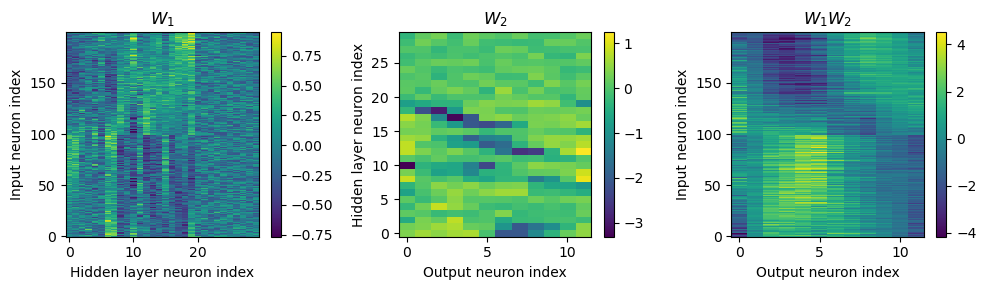

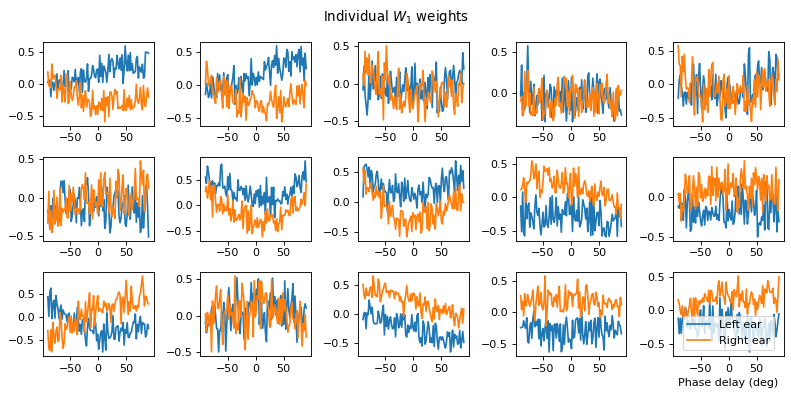

In [34]:
w1 = W1.detach().cpu().numpy()
w2 = W2.detach().cpu().numpy()

# for each column of w1, compute the weighted mean and re-order according to that
A = np.arange(w1.shape[0])[:, None]
weighted_mean = np.mean((A*w1), axis=0)
weighted_mean[np.max(np.abs(w1), axis=0)<.5] = np.inf
I = np.argsort(weighted_mean)
w1 = w1[:, I]
w2 = w2[I, :]

# Plot the re-ordered weight matrices
plt.figure(figsize=(10, 3), dpi=100)
plt.subplot(131)
plt.imshow(w1, interpolation='nearest', aspect='auto', origin='lower')
plt.ylabel('Input neuron index')
plt.xlabel('Hidden layer neuron index')
plt.title('$W_1$')
plt.colorbar()
plt.subplot(132)
plt.imshow(w2, interpolation='nearest', aspect='auto', origin='lower')
plt.ylabel('Hidden layer neuron index')
plt.xlabel('Output neuron index')
plt.title('$W_2$')
plt.colorbar()
plt.subplot(133)
plt.imshow(w1@w2, interpolation='nearest', aspect='auto', origin='lower')
plt.ylabel('Input neuron index')
plt.xlabel('Output neuron index')
plt.title('$W_1W_2$')
plt.colorbar()
plt.tight_layout()

# Plot some sample weights for hidden neurons
I_nz, = (np.max(np.abs(w1), axis=0)>.5).nonzero()
plt.figure(figsize=(10, 5), dpi=80)
phi = np.linspace(-np.pi/2, np.pi/2, w1.shape[0]//2)
for i, j in list(enumerate(I_nz))[:15]:
    plt.subplot(3, 5, i+1)
    plt.plot(phi*180/np.pi, w1[:w1.shape[0]//2, j], label="Left ear")
    plt.plot(phi*180/np.pi, w1[w1.shape[0]//2:, j], label="Right ear")
plt.suptitle("Individual $W_1$ weights")
plt.legend(loc='best')
plt.xlabel('Phase delay (deg)')
plt.tight_layout()

Analyse unit activity from s_rec_results and s_labels_results

In [35]:
mean_matrix = np.zeros((num_classes, num_hidden))

for i in range(s_rec_results.shape[0]):
    current_recs = s_rec_results[i]
    recording_means = np.sum(current_recs, axis=0)
    
    current_label = s_labels_results[i]
    
    for j in range(num_hidden):
        mean_matrix[int(current_label), j] = recording_means[j]

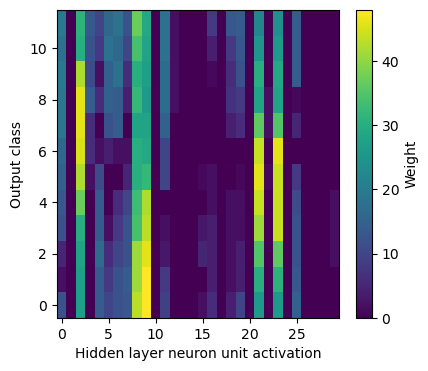

In [36]:
plt.figure(figsize=(10, 4), dpi=100)
plt.subplot(121)
plt.imshow(mean_matrix, interpolation='nearest', aspect='auto', origin='lower')
plt.ylabel('Output class')
plt.xlabel('Hidden layer neuron unit activation')
plt.colorbar(label="Weight")

## Part 1: Use Neural decoding package to predict classes based on internal hidden spike states (observability)
#### The following decoders are used: Wiener Filter, Wiener Cascade, SVRegression, XGBoost, SimpleRNN, GRU, LSTM

This part requires keras and tensorflow

In [37]:
# import decoders and warnings
import sys
# Append the directory to your Python path
sys.path.append('neural-decoding-package')

# Now you can import the decoders module as if it were in your working directory
import decoders
import warnings


warnings.filterwarnings('ignore')

In [38]:
# Data split 80/20
# Split data 80/20
n_trials = s_rec_results.shape[0]
split = int(n_trials*4/5)

rec_shape = s_rec_results.shape
label_shape = s_labels_results.shape
s_rec_reshaped = s_rec_results.reshape(rec_shape[0], -1)

training_data = s_rec_reshaped[:split]
validation_data = s_rec_reshaped[split:]

training_decisions = s_labels_results[:split]
validation_decisions = s_labels_results[split:]

Let's fit a linear regression or Wiener filter first

In [18]:
wiener_filter = decoders.WienerFilterRegression()
wiener_filter.fit(training_data, training_decisions)

Accuracy on training data

In [18]:
predictions = np.round(wiener_filter.predict(training_data))
accuracy = np.sum(predictions == training_decisions) / float(len(predictions))
print("Acc on training:", f"{round(accuracy*100, 2)}%")

Acc on training: 96.25%


Accuracy on validation data

In [19]:
predictions = np.round(wiener_filter.predict(validation_data))
accuracy = np.sum(predictions == validation_decisions) / float(len(predictions))
print("Acc on validation:", f"{round(accuracy*100, 2)}%")

Acc on validation: 72.56%


Let's try a Wiener Cascade Regression

In [20]:
wiener_filter_cascade = decoders.WienerCascadeRegression()
wiener_filter_cascade.fit(training_data, training_decisions.reshape(-1, 1))

In [21]:
predictions = np.round(wiener_filter_cascade.predict(training_data)).flatten()
accuracy = np.sum(predictions == training_decisions) / float(len(predictions))
print("Acc on training:", f"{round(accuracy*100, 2)}%")

predictions = np.round(wiener_filter_cascade.predict(validation_data)).flatten()
accuracy = np.sum(predictions == validation_decisions) / float(len(predictions))
print("Acc on training:", f"{round(accuracy*100, 2)}%")

Acc on training: 96.28%
Acc on training: 73.29%


Let's try Support Vector Regression

In [22]:
svr_model = decoders.SVRegression(1000, 3.0)
svr_model.fit(training_data, training_decisions.reshape(-1, 1))


In [23]:
predictions = np.round(svr_model.predict(training_data)).flatten()
accuracy = np.sum(predictions == training_decisions) / float(len(predictions))
print("Acc on training:", f"{round(accuracy*100, 2)}%")

predictions = np.round(svr_model.predict(validation_data)).flatten()
accuracy = np.sum(predictions == validation_decisions) / float(len(predictions))
print("Acc on training:", f"{round(accuracy*100, 2)}%")

Acc on training: 100.0%
Acc on training: 81.83%


Let's try XgBoost

In [73]:
# not able to run on apple silicon
XGB_classifier = decoders.XGBoostClassification(gpu=0, num_round = 100,
                                       max_depth = 5, eta=0.01)

XGB_classifier.fit(training_data, training_decisions)

In [ ]:
predictions = np.round(XGB_classifier.predict(training_data)).flatten()
accuracy = np.sum(predictions == training_decisions) / float(len(predictions))
print("Acc on training:", f"{round(accuracy*100, 2)}%")

predictions = np.round(XGB_classifier.predict(validation_data)).flatten()
accuracy = np.sum(predictions == validation_decisions) / float(len(predictions))
print("Acc on training:", f"{round(accuracy*100, 2)}%")

Simple RNN Classification

In [39]:
# Data split 80/20
# Split data 80/20
n_trials = s_rec_results.shape[0]
split = int(n_trials*4/5)

training_data = s_rec_results[:split]
validation_data = s_rec_results[split:]

training_decisions = s_labels_results[:split]
validation_decisions = s_labels_results[split:]

In [25]:
rnn_class = decoders.SimpleRNNClassification(units = 50, dropout = 0, num_epochs =250, verbose = 1)
rnn_class.fit(training_data, training_decisions.reshape(-1, 1))

Epoch 1/250


2024-03-24 20:39:18.710362: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


103/103 [==============================] - 1s 6ms/step - loss: 1.9034 - accuracy: 0.3562
Epoch 2/250
103/103 [==============================] - 1s 6ms/step - loss: 1.4529 - accuracy: 0.5476
Epoch 3/250
103/103 [==============================] - 1s 6ms/step - loss: 1.2555 - accuracy: 0.6203
Epoch 4/250
103/103 [==============================] - 1s 7ms/step - loss: 1.0933 - accuracy: 0.6575
Epoch 5/250
103/103 [==============================] - 1s 6ms/step - loss: 0.9689 - accuracy: 0.6859
Epoch 6/250
103/103 [==============================] - 1s 6ms/step - loss: 0.8749 - accuracy: 0.6944
Epoch 7/250
103/103 [==============================] - 1s 6ms/step - loss: 0.7986 - accuracy: 0.7201
Epoch 8/250
103/103 [==============================] - 1s 6ms/step - loss: 0.7398 - accuracy: 0.7149
Epoch 9/250
103/103 [==============================] - 1s 7ms/step - loss: 0.6907 - accuracy: 0.7329
Epoch 10/250
103/103 [==============================] - 1s 6ms/step - loss: 0.6693 - accuracy: 0.7237
E

In [26]:
predictions = np.round(rnn_class.predict(training_data)).flatten()
accuracy = np.sum(predictions == training_decisions) / float(len(predictions))
print("Acc on training:", f"{round(accuracy*100, 2)}%")

predictions = np.round(rnn_class.predict(validation_data)).flatten()
accuracy = np.sum(predictions == validation_decisions) / float(len(predictions))
print("Acc on training:", f"{round(accuracy*100, 2)}%")

103/103 [==============================] - 0s 2ms/step
Acc on training: 94.6%
26/26 [==============================] - 0s 2ms/step
Acc on training: 76.95%


Gated Recurrent Units - determine how much information can flow through various parts of the network

In [27]:
GRU_classifier = decoders.GRUClassification(units = 100,
                                              dropout = .1,
                                              num_epochs =30,
                                              verbose = 1)

GRU_classifier.fit(training_data, training_decisions)

Epoch 1/30
103/103 [==============================] - 7s 55ms/step - loss: 1.7477 - accuracy: 0.3727
Epoch 2/30
103/103 [==============================] - 6s 56ms/step - loss: 1.2881 - accuracy: 0.5104
Epoch 3/30
103/103 [==============================] - 6s 56ms/step - loss: 1.0998 - accuracy: 0.5641
Epoch 4/30
103/103 [==============================] - 6s 56ms/step - loss: 0.9870 - accuracy: 0.5879
Epoch 5/30
103/103 [==============================] - 6s 56ms/step - loss: 0.9155 - accuracy: 0.6136
Epoch 6/30
103/103 [==============================] - 6s 56ms/step - loss: 0.8575 - accuracy: 0.6297
Epoch 7/30
103/103 [==============================] - 6s 56ms/step - loss: 0.8083 - accuracy: 0.6477
Epoch 8/30
103/103 [==============================] - 6s 56ms/step - loss: 0.7734 - accuracy: 0.6694
Epoch 9/30
103/103 [==============================] - 6s 57ms/step - loss: 0.7768 - accuracy: 0.6493
Epoch 10/30
103/103 [==============================] - 6s 58ms/step - loss: 0.7407 - accura

In [28]:
predictions = np.round(GRU_classifier.predict(training_data)).flatten()
accuracy = np.sum(predictions == training_decisions) / float(len(predictions))
print("Acc on training:", f"{round(accuracy*100, 2)}%")

predictions = np.round(GRU_classifier.predict(validation_data)).flatten()
accuracy = np.sum(predictions == validation_decisions) / float(len(predictions))
print("Acc on training:", f"{round(accuracy*100, 2)}%")

103/103 [==============================] - 1s 9ms/step
Acc on training: 62.94%
26/26 [==============================] - 0s 10ms/step
Acc on training: 58.41%


Long short-therm memory network

In [29]:
LSTM_classifier = decoders.LSTMClassification(units = 100,
                                                  dropout = 0,
                                                    num_epochs =100,
                                                    verbose = 1)


LSTM_classifier.fit(training_data, training_decisions)

Epoch 1/100


2024-03-24 20:44:48.799789: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-24 20:44:48.801473: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-24 20:44:48.802097: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

103/103 [==============================] - 4s 35ms/step - loss: 1.6744 - accuracy: 0.3858
Epoch 2/100
103/103 [==============================] - 4s 35ms/step - loss: 1.1482 - accuracy: 0.5333
Epoch 3/100
103/103 [==============================] - 4s 35ms/step - loss: 0.9477 - accuracy: 0.6053
Epoch 4/100
103/103 [==============================] - 4s 36ms/step - loss: 0.8190 - accuracy: 0.6606
Epoch 5/100
103/103 [==============================] - 4s 36ms/step - loss: 0.7586 - accuracy: 0.6654
Epoch 6/100
103/103 [==============================] - 4s 35ms/step - loss: 0.6990 - accuracy: 0.6938
Epoch 7/100
103/103 [==============================] - 4s 35ms/step - loss: 0.6840 - accuracy: 0.7048
Epoch 8/100
103/103 [==============================] - 4s 36ms/step - loss: 0.6497 - accuracy: 0.7207
Epoch 9/100
103/103 [==============================] - 4s 35ms/step - loss: 0.6384 - accuracy: 0.7332
Epoch 10/100
103/103 [==============================] - 4s 37ms/step - loss: 0.5939 - accuracy

In [30]:
predictions = np.round(LSTM_classifier.predict(training_data)).flatten()
accuracy = np.sum(predictions == training_decisions) / float(len(predictions))
print("Acc on training:", f"{round(accuracy*100, 2)}%")

predictions = np.round(LSTM_classifier.predict(validation_data)).flatten()
accuracy = np.sum(predictions == validation_decisions) / float(len(predictions))
print("Acc on training:", f"{round(accuracy*100, 2)}%")

  6/103 [>.............................] - ETA: 1s 

2024-03-24 20:50:54.222429: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-24 20:50:54.223079: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-24 20:50:54.223799: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

103/103 [==============================] - 1s 11ms/step
Acc on training: 93.22%
26/26 [==============================] - 0s 13ms/step
Acc on training: 84.02%


Ensemble Method using tensortools

In [16]:
!pip install git+https://github.com/neurostatslab/tensortools

  Cloning https://github.com/neurostatslab/tensortools to /private/var/folders/62/9yvykkwd67x92x4q3877tqzh0000gn/T/pip-req-build-6e6ng3bq
  Running command git clone --filter=blob:none --quiet https://github.com/neurostatslab/tensortools /private/var/folders/62/9yvykkwd67x92x4q3877tqzh0000gn/T/pip-req-build-6e6ng3bq
  Resolved https://github.com/neurostatslab/tensortools to commit 9e732ac5f27e8f993751122ad0d09f1318528bf5
  Preparing metadata (setup.py) ... done


In [20]:
import tensortools as tt

In [21]:
ensemble = tt.Ensemble(fit_method="ncp_hals")
ensemble.fit(training_data, ranks=range(1, 9), replicates=4)

Rank-1 models:  min obj, 0.82;  max obj, 0.82;  time to fit, 2.0s


Rank-2 models:  min obj, 0.79;  max obj, 0.79;  time to fit, 4.9s


Rank-3 models:  min obj, 0.77;  max obj, 0.77;  time to fit, 7.6s


Rank-4 models:  min obj, 0.75;  max obj, 0.76;  time to fit, 9.3s


Rank-5 models:  min obj, 0.74;  max obj, 0.75;  time to fit, 8.8s


Rank-6 models:  min obj, 0.73;  max obj, 0.74;  time to fit, 11.9s


Rank-7 models:  min obj, 0.72;  max obj, 0.72;  time to fit, 11.4s


Rank-8 models:  min obj, 0.71;  max obj, 0.73;  time to fit, 16.4s


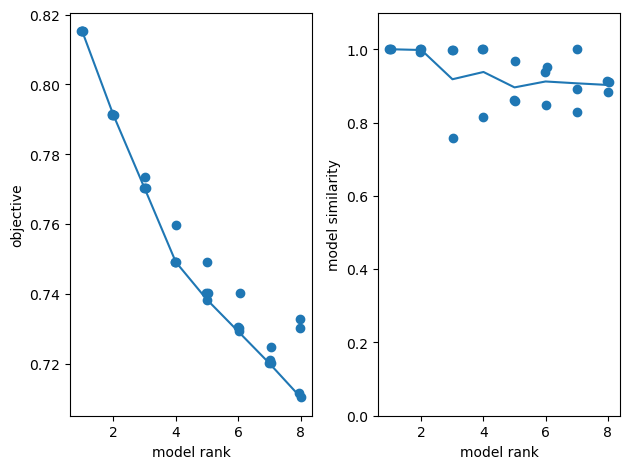

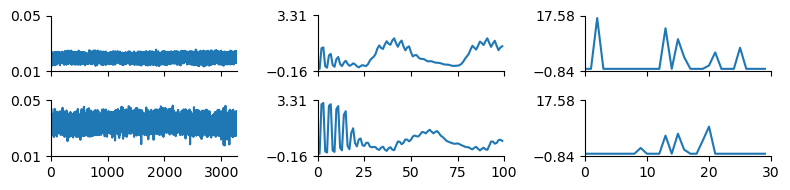

In [42]:

fig, axes = plt.subplots(1, 2)
tt.plot_objective(ensemble, ax=axes[0])   # plot reconstruction error as a function of num components.
tt.plot_similarity(ensemble, ax=axes[1])  # plot model similarity as a function of num components.
fig.tight_layout()

# Plot the low-d factors for an example model, e.g. rank-2, first optimization run / replicate.
num_components = 2
replicate = 0
tt.plot_factors(ensemble.factors(num_components)[replicate])  # plot the low-d factors

plt.show()

#### Part 2: Manipulate unit activity
Silencing, over-activation, multi-lesion approach.

In [89]:
def forwardPassWithSilence(ipds, spikes, label, run, silence):
  accs = []
  for x_local, y_local in data_generator(ipds, spikes):
    y_local_orig = y_local
    y_local = discretise(y_local)
    output = snn(x_local, W1, W2, tau=20*ms, silence=silence)[0]
    m = torch.sum(output, 1)
    _, am = torch.max(m, 1)
    tmp = np.mean((y_local == am).detach().cpu().numpy())
    accs.append(tmp)
  print()
  acc = 100*np.mean(accs)
  print(f"{label} classifier accuracy: {acc:.1f}%")
  return acc

In [80]:
# Perform a forward pass with all 0s -> should have random acc
forwardPassWithSilence(ipds_test, spikes_test, 'test', run=run_func, silence=torch.zeros(num_hidden))


test classifier accuracy: 8.1%


In [82]:
# Perform a forward pass with all 1s -> should have about 60% acc
forwardPassWithSilence(ipds_test, spikes_test, 'test', run=run_func, silence=torch.ones(num_hidden))


test classifier accuracy: 62.5%


In [92]:
# try to silence them one by one and see the result
silence = torch.ones(num_hidden)
accs = []
for i in range(num_hidden):
    silence[i] = 0
    acc = forwardPassWithSilence(ipds_test, spikes_test, f'test {i}: ', run=run_func, silence=silence)
    accs.append(acc)
    silence[i] = 1
    



test 0:  classifier accuracy: 43.4%

test 1:  classifier accuracy: 62.5%

test 2:  classifier accuracy: 52.1%

test 3:  classifier accuracy: 46.9%

test 4:  classifier accuracy: 59.1%

test 5:  classifier accuracy: 61.2%

test 6:  classifier accuracy: 55.4%

test 7:  classifier accuracy: 59.0%

test 8:  classifier accuracy: 56.7%

test 9:  classifier accuracy: 52.6%

test 10:  classifier accuracy: 62.5%

test 11:  classifier accuracy: 47.3%

test 12:  classifier accuracy: 62.8%

test 13:  classifier accuracy: 62.5%

test 14:  classifier accuracy: 62.5%

test 15:  classifier accuracy: 63.0%

test 16:  classifier accuracy: 59.5%

test 17:  classifier accuracy: 62.5%

test 18:  classifier accuracy: 62.7%

test 19:  classifier accuracy: 61.9%

test 20:  classifier accuracy: 62.4%

test 21:  classifier accuracy: 57.6%

test 22:  classifier accuracy: 62.6%

test 23:  classifier accuracy: 60.2%

test 24:  classifier accuracy: 62.5%

test 25:  classifier accuracy: 44.8%

test 26:  classifier 

In [90]:
def plot_accs_silenced_neuron(neurons, accs):
    plt.figure(figsize=(10, 6))
    plt.plot(neurons, accs, marker='o')
    plt.title('Accuracy as a function of the silenced neuron')
    plt.xlabel('Silenced Neuron')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.show()

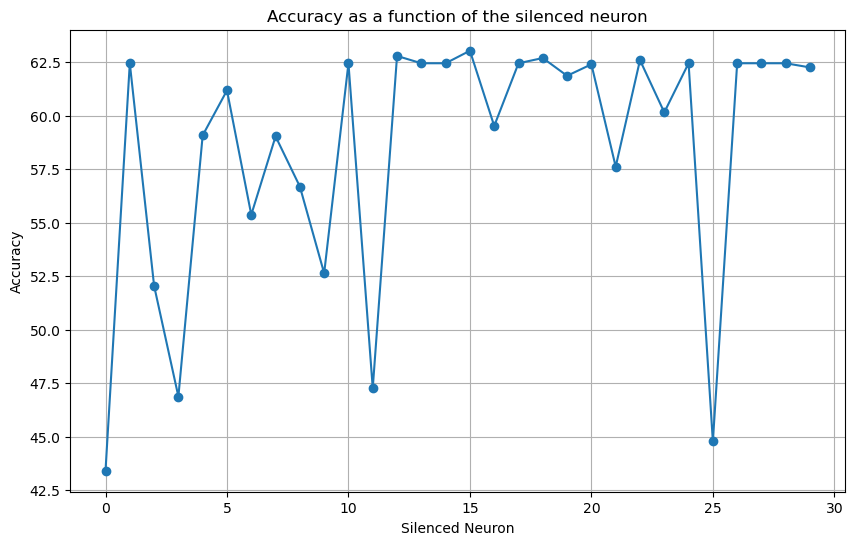

In [94]:
neurons = list(range(0, 30))
plot_accs_silenced_neuron(neurons, accs)